# Figure 4b

Energy as a function of time.

In [22]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt

sys.path.insert(0, '../../icenumerics/')
sys.path.insert(0, './auxnumerics/')
import icenumerics as ice

from numba import jit
import auxiliary as aux
import montecarlo_tools as mc
import chirality_tools as chir
import energy
from parameters import params
ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [23]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Visualization

In [24]:
sim_path = '../data/sims/'
data_path = '/media/eru/ina/stuckgs/data/'
energies = pd.read_csv(os.path.join(sim_path,'energiestime.csv'), index_col=['realization','frame'])
energies_gs = pd.read_csv(os.path.join(sim_path,'gs30_energy.csv'), index_col=['t'])

In [25]:
frames = energies.index.get_level_values('frame').unique().to_list()
realizations = energies.index.get_level_values('realization').unique().to_list()
time = np.array(frames) / params['framespersec'].magnitude
field = 10/300 * time
enp = energies['energy'].to_numpy().reshape((len(realizations),len(frames)))
eav = enp.mean(axis=0)
estd = enp.std(axis=0)

In [5]:
gs = pd.read_csv('../data/states/af4/30.csv', index_col='id')
gs_energies = []
for cfield in tqdm(field):
    ufield = cfield*ureg.mT
    dip_moment = np.pi * (2*params['particle_radius'])**3 *params['particle_susceptibility']*ufield/6/params['mu0']
    magic_number =  - (params['mu0']*dip_moment**2/4/np.pi).to(ureg.pN * ureg.nm * ureg.um**3).magnitude
    L  = 30 * params['lattice_constant'].magnitude
    sel_particles = aux.get_positions_from_ctrj(gs).to_numpy()
    gs_energy = energy.calculate_energy(magic_number,L,sel_particles)
    gs_energies.append(gs_energy)

100%|██████████| 301/301 [03:01<00:00,  1.66it/s]


In [42]:
energies_gs = pd.read_csv('../data/sims/gs30_energy.csv',index_col=0)
dE = enp - energies_gs['energy'][:301].to_numpy()
eta = dE/params['size']**2/params['kbT'].magnitude
eta_mean = eta.mean(axis=0)
eta_std = eta.std(axis=0)

In [52]:
eta_mean[::20]

array([ 0.        ,  1.19473214,  2.82887055,  4.2403739 ,  6.39853839,
        9.16207262, 12.40616428, 16.2253153 , 20.42917236, 24.99847707,
       29.84599303, 34.9316503 , 40.01735222, 44.9277357 , 49.64013675,
       53.74524509])

In [58]:
len(eta_mean[::5])

61

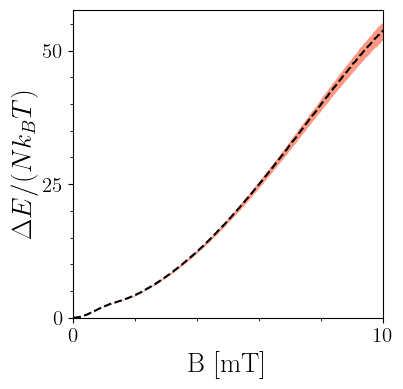

In [79]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(field,eta_mean,'--',linewidth=1.5, color='k')
ax.fill_between(field,eta_mean-eta_std,eta_mean+eta_std, alpha=1,edgecolor='#FF2D00', facecolor='#FF9882',
    linewidth=0)

ax.set_xlim(0,10)
ax.set_ylim(0,np.max(eta))

ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.xaxis.set_minor_formatter(plt.NullFormatter())


ax.yaxis.set_major_locator(plt.MultipleLocator(25))
ax.yaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_minor_formatter(plt.NullFormatter())


ax.set_xlabel('B [mT]', fontsize=20)
ax.set_ylabel(r'$\Delta E/ (Nk_BT)$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.minorticks_on()

plt.show()

fig.savefig(os.path.join(data_path,'figs/fig4b.png'),dpi=300,bbox_inches='tight')
fig.savefig(os.path.join(data_path,'figs/fig4b.pdf'),bbox_inches='tight')